# Offline RL (80 Points)

> Name: Ahmad Karami


In this notebook, we will implement the Soft Actor Critic (SAC) algorithm on the CartPole environment in both online and offline settings. The SAC framework focuses on maximizing the expected reward while also maximizing entropy, meaning the actor aims to succeed at the task while maintaining a high level of randomness in its actions. This approach explicitly encourages exploration by seeking a high entropy in the policy.

In the second part, we will use the policy learned in the first part to collect a dataset of expert trajectories and perform behavioral cloning.

*The existing results are the baseline for the quality of your implementation.*

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
import numpy as np
import random
import  gymnasium                as      gym
import matplotlib.pyplot as plt
import imageio
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
from IPython.display import HTML
from base64 import b64encode

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

### Functions for showing results

In [57]:
import logging
logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)


def plot_rewards(sum_of_rewards, show_result=None , bove = None,dn = None):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result is not None:
        plt.title(f'{show_result}')
    else:
        plt.clf()
        plt.title('Training...')
    if bove is not None:
        plt.xlabel(f'{bove}')
    else:
        plt.xlabel('Episode')
    if dn is not None:
        plt.xlabel(f'{dn}')
    else:
        plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def Plot(losses):
    _, ax = plt.subplots(figsize=(12, 6))

    # Plot the losses as a bar chart
    ax.bar(range(len(losses)), losses, color='#4c72b0', edgecolor='black', linewidth=3)

    # Add labels and title
    ax.set_title('Behavioural Cloning', fontsize=18, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)

    # Format the x-axis ticks
    ax.set_xticks(range(len(losses)))
    ax.set_xticklabels([f'{i+1}' for i in range(len(losses))], rotation=45, ha='right', fontsize=12)

    # Format the y-axis ticks
    ax.set_yticks(np.arange(0, max(losses)+1, 1))
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Annotate the minimum loss value
    min_loss = min(losses)
    min_idx = losses.index(min_loss)
    ax.text(min_idx, min_loss + 0.2, f'Minimum Loss: {min_loss:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    max_loss = max(losses)
    max_idx = losses.index(max_loss)
    ax.text(max_idx, max_loss + 0.2, f'Minimum Loss: {max_loss:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Add a legend
    ax.legend(['Training Loss'], loc='upper right', fontsize=12)

    # Adjust the layout
    plt.tight_layout()

    # Display the plot
    plt.show()

## Network Structure (10 points)
For constructing SAC agent, we use objects of feedforward neural networks with 3 layers. Complete the code below.

In [4]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        ##########################################################
        self.layer_1 = nn.Linear(in_features=input_dimension, out_features=128)
        self.layer_2 = nn.Linear(in_features=128, out_features=128)
        self.layer_3 = nn.Linear(in_features=128, out_features=output_dimension)
        self.output_activation = output_activation
        ##########################################################

    def forward(self, inpt):
        ##########################################################
        output = F.relu(self.layer_1(inpt))
        output = F.relu(self.layer_2(output))
        output = self.output_activation(self.layer_3(output))
        ##########################################################

        return output

## Replay Buffer

A SAC agent requires a replay buffer to sample previously visited states. You can utilize the implemented code below to set up this replay buffer.

In [6]:
import numpy as np


class ReplayBuffer:

    def __init__(self, environment, capacity=500000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 1e-2
        self.delta = 1e-4
        self.indices = None
        self.mirror_index = np.random.permutation(range(self.buffer.shape[0]))

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, bool'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100, batch_deterministic_start=None):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        if batch_deterministic_start is None:
            self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        else:
            self.indices = self.mirror_index[batch_deterministic_start:batch_deterministic_start+size]
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count

## SAC Agent (50 points)

Now complete the following class. You can use the auxiliary methods provided in the class.

In [ ]:
class SACAgent:
    def __init__(self, environment, replay_buffer=None, learning_rate=3e-4, discount=0.99, buffer_batch_size=100, alpha_init=1, interpolation_factor=0.01):
        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n

        self.alpha_init = alpha_init
        self.learning_rate = learning_rate
        self.discount = discount
        self.buffer_batch_size = buffer_batch_size
        self.interpolation_factor = interpolation_factor

        self.replay_buffer = ReplayBuffer(self.environment) if replay_buffer is None else replay_buffer

        ##########################################################
        # Define critics usig your implemented feed forward netwrok
        ##########################################################
        # print('state and action sizes:',self.state_dim,self.action_dim)
        self.critic_local = Network(input_dimension=self.state_dim,output_dimension=self.action_dim)
        self.critic_local2 = Network(input_dimension=self.state_dim, output_dimension=self.action_dim)
        self.critic_optimiser = torch.optim.Adam(self.critic_local.parameters(), lr=self.learning_rate)
        self.critic_optimiser2 = torch.optim.Adam(self.critic_local2.parameters(), lr=self.learning_rate)
        self.critic_target = Network(input_dimension=self.state_dim, output_dimension=self.action_dim)
        self.critic_target2 = Network(input_dimension=self.state_dim,output_dimension=self.action_dim)
        ##########################################################

        self.soft_update_target_networks(tau=1.)

        ##########################################################
        # Define the actor
        # Define the actor optimizer
        ##########################################################
        self.actor_local = Network(input_dimension=self.state_dim, output_dimension=self.action_dim, output_activation=torch.nn.Softmax(dim=-1))
        self.actor_optimiser = optim.Adam(self.actor_local.parameters(), lr=self.learning_rate)
        ##########################################################
        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(self.alpha_init), requires_grad=True)
        self.alpha = self.log_alpha
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=self.learning_rate)

    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor,
                    next_states_tensor, done_tensor):
        ##########################################################
        # You are going to calculate critic losses in this method
        ##########################################################
        with torch.no_grad():
            action_probabilities, log_action_probabilities = self.get_action_info(next_states_tensor)
            next_actions = (torch.multinomial(action_probabilities, 1).squeeze(1)).unsqueeze(1)

            # Get the values that the Q-values of the next states should be according to the target network
            next_q_values_target = self.critic_target.forward(next_states_tensor).gather(1, next_actions)
            next_q_values_target2 = self.critic_target2.forward(next_states_tensor).gather(1, next_actions)

            
            next_q_values = torch.min(next_q_values_target, next_q_values_target2) - self.alpha * (log_action_probabilities.gather(1, next_actions))
            target_q = rewards_tensor.unsqueeze(-1) + (1 - done_tensor.unsqueeze(-1)) * self.discount * next_q_values

        # Critic loss is the mean square difference between the Q-values expected by the current critic
        # and y(r,s',d)
        q_values = self.critic_local(states_tensor).gather(1, actions_tensor.unsqueeze(-1))
        q_values2 = self.critic_local2(states_tensor).gather(1, actions_tensor.unsqueeze(-1))
        
        critic_loss = torch.nn.MSELoss()(q_values, target_q)
        critic2_loss = torch.nn.MSELoss()(q_values2, target_q)

        return critic_loss, critic2_loss
        ##########################################################

    def actor_loss(self, states_tensor):
        ##########################################################
        # Implement the actor loss
        ##########################################################
        action_probabilities, log_action_probabilities = self.get_action_info(states_tensor)

        inside_term = self.log_alpha.detach().exp() * log_action_probabilities - self.predict_q_values(states_tensor)
        actor_loss = (action_probabilities * inside_term).sum(dim=1).mean()
        return actor_loss, log_action_probabilities
        ##########################################################

    def train_on_transition(self, state, discrete_action, next_state, reward, done):
        transition = (state, discrete_action, reward, next_state, done)
        self.train_networks(transition)

    def train_networks(self, transition=None, batch_deterministic_start=None):
        ##########################################################
        # Set all the gradients stored in the optimizers to zero
        # Add the new transition to the replay buffer for online case
        ##########################################################
        self.critic_optimiser.zero_grad()
        self.critic_optimiser2.zero_grad()
        self.actor_optimiser.zero_grad()
        self.alpha_optimiser.zero_grad()

        if transition is not None:
            self.replay_buffer.add_transition(transition)

        if self.replay_buffer.get_size() >= self.buffer_batch_size:
            minibatch = self.replay_buffer.sample_minibatch(self.buffer_batch_size, batch_deterministic_start=batch_deterministic_start)
            minibatch_separated = list(map(list, zip(*minibatch)))

            states_tensor = torch.tensor(np.array(minibatch_separated[0]))
            actions_tensor = torch.tensor(np.array(minibatch_separated[1]), dtype = torch.int64)
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float()
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3]))
            done_tensor = torch.tensor(np.array(minibatch_separated[4])).float()

            ##########################################################
            # compute the critic loss and perform the backpropagation,
            # then compute the actor loss and backpropagate the gradient on it
            # You also need to update \alpha
            ##########################################################
            critic_loss, critic2_loss = self.critic_loss(states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor)
            critic_loss.backward()
            critic2_loss.backward()
            self.critic_optimiser.step()
            self.critic_optimiser2.step()

            actor_loss, log_action_probabilities = self.actor_loss(states_tensor)
            actor_loss.backward()
            self.actor_optimiser.step()

            alpha_loss = self.temperature_loss(log_action_probabilities)
            alpha_loss.backward()
            self.alpha_optimiser.step()
            self.alpha = self.log_alpha.exp()

            self.soft_update_target_networks(self.interpolation_factor)

    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
        return alpha_loss

    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor)
        # z is a mask to avoid calculating log(0)
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities

    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probabilities = self.actor_local.forward(state_tensor)
        action_probabilities = action_probabilities.squeeze(0).detach().numpy()
        return action_probabilities

    def soft_update_target_networks(self, tau):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

    def predict_q_values(self, state):
        q_values = self.critic_local(state)
        q_values2 = self.critic_local2(state)
        return torch.min(q_values, q_values2)

## Online SAC (10 points)

Now evaluate your model in CartPole environment in the online setting. After each 4 episodes, you should evaluate your model on a separate test environment. Run your model 4 times separately and plot the mean and deviation of the evaluation curves.

**NOTE:** Since you are going to use the replay buffer of this agent as the offline dataset, you may want to save it for later use.

In [ ]:
TRAINING_EVALUATION_RATIO = 4
EPISODES_PER_RUN = 500
STEPS_PER_EPISODE = 200
env = gym.make("CartPole-v1")
# env.new_step_api = True

agent = SACAgent(env)

def eval():
  returns = []
  # Evaluate the agent for 5 episodes
  for _ in range(2):
    # Reset the environment
    state,_ = env.reset()
    episode_return = 0
    for _ in range(STEPS_PER_EPISODE):
      # Get the agent's action
      action = agent.get_next_action(state, evaluation_episode=True)
      # Take a step in the environment
      next_state, reward, done, truncated,_ = env.step(action)
      # Update the episode return
      episode_return += reward
      # Update the state
      state = next_state
      # Check for termination conditions
      if done or truncated:
          break

    returns.append(episode_return)
  return returns

In [9]:
rewards_avrg=[]
for episode in range(EPISODES_PER_RUN):
  state,_= env.reset()
  total_return = 0
  for step in range(STEPS_PER_EPISODE):
    # Get the agent's action
    action = agent.get_next_action(state)
    # Take a step in the environment
    next_state, reward, done, truncated,_ = env.step(action)
    # Train the agent on the transition
    agent.train_on_transition(state, action, next_state, reward, done)
    # Update the total return
    total_return += reward
    state = next_state
    if done or truncated:
      break
    
  if episode % TRAINING_EVALUATION_RATIO == 0:
    returns = eval()
    mean_return = np.mean(returns)
    rewards_avrg.append(mean_return)
    plot_rewards(rewards_avrg)
env.close()


<Figure size 1200x600 with 0 Axes>

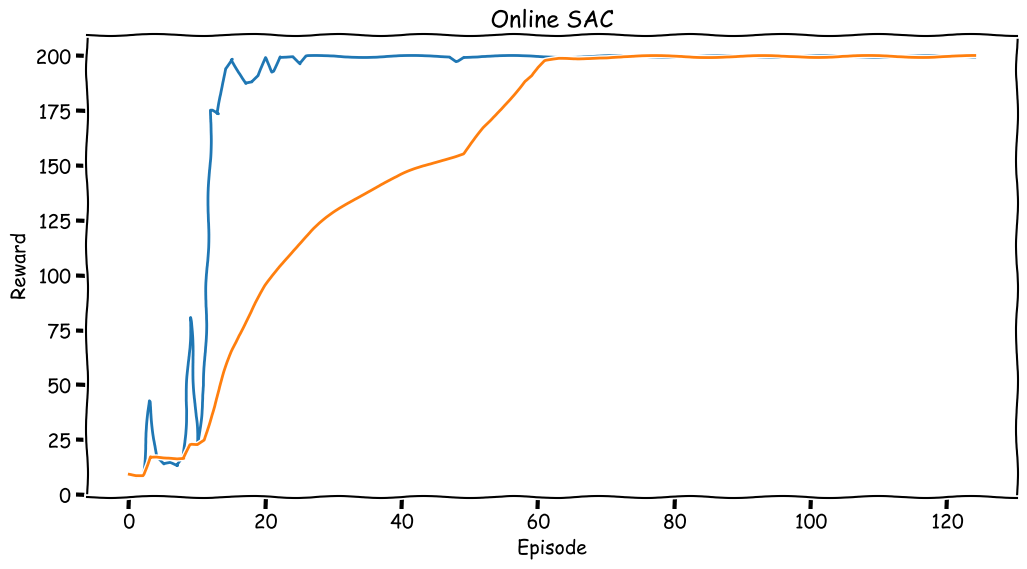

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [10]:
plot_rewards(rewards_avrg, show_result='Online SAC')
plt.ioff()
plt.show()


In [11]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state, _ = env.reset()
for _ in range(300):
    frames.append(env.render())
    action = agent.get_next_action(state, evaluation_episode=True)
    state, reward, done, truncated, info = env.step(action)
    if done or truncated:
        break

env.close()
imageio.mimsave('./online.mp4', frames, fps=25)
show_video('./online.mp4')



e:\Program_Files\Anaconda\envs\DRL\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## Offline SAC (10 points)

In this part you are going to train an SAC agent using the replay buffer from the online agent. During training you sample from this replay buffer and train the offline agent **without adding transitions to the replay buffer**. The loss function and every thing else is the same as the online setting.

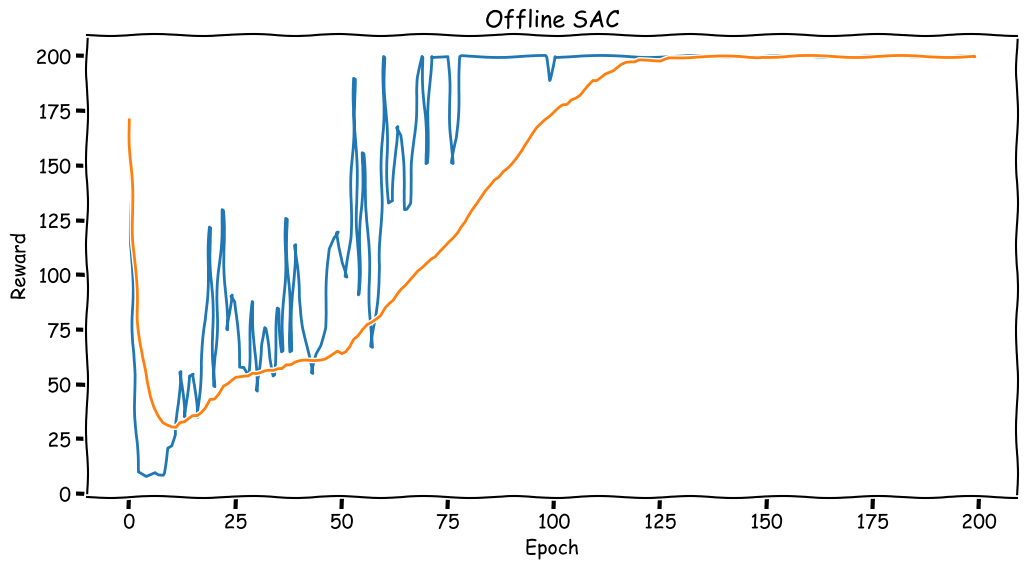

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [25]:
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100
STEPS_PER_EPISODE = 200

env = gym.make("CartPole-v1")

##########################################################
# Implement the training loop for the offline SAC.
# After each epoch, run  validation
# and plot the mean return over these
# episodes in the end
##########################################################

# Initialize the environment and the offline SAC agent
offline_sac_agent = SACAgent(env, replay_buffer=agent.replay_buffer)


rewards = []
for epoch in range(NUM_EPOCHS):
    # training
    for _ in range(EPISODES_PER_RUN):
        offline_sac_agent.train_networks()

    # evaluation 
    total_reward = 0
    state, _ = env.reset()
    for _ in range(STEPS_PER_EPISODE):
        with torch.no_grad():
            action = offline_sac_agent.get_next_action(state, evaluation_episode=True)
        
        next_state, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        state = next_state
        if done or truncated:
            break
    rewards.append(total_reward)
env.close()

plot_rewards(rewards, show_result='Offline SAC', bove= 'Epoch')
plt.ioff()
plt.show()

In [28]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state, _ = env.reset()
for _ in range(200):
    frames.append(env.render())
    action = offline_SAC.get_next_action(state, evaluation_episode=True)
    state, reward, done, truncated, info = env.step(action)
    if done or truncated:
        break

env.close()
imageio.mimsave('./online.mp4', frames, fps=25)
show_video('./online.mp4')

 # Behavioural Cloning (20 points)

Behavioral cloning works by mimicking expert behavior through supervised learning. It involves collecting a dataset of expert trajectories, which are sequences of state-action pairs (unlike offline reinforcement learning, which also collects rewards to train the model). The model is then trained to predict the expert's actions based on the observed states. The goal is for the model to replicate the expert's behavior by minimizing the difference between its predicted actions and the expert's actions.

We first need to collect data using the previously trained model.

In [36]:
done = False
T = False
while not (done or T):
    print(2)
    break

2


In [39]:
env = gym.make('CartPole-v1')
num_episodes = 1000
expert_data = []

# Collect state-action pairs
for _ in range(num_episodes):
    state, _ = env.reset()
    done , truncated= False, False
    while not (done or truncated):
        action = agent.get_next_action(state, evaluation_episode=True)
        next_state, reward, done, truncated, _ = env.step(action)
        expert_data.append((state, action))
        state = next_state

e:\Program_Files\Anaconda\envs\DRL\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Define the model for behaviuoral cloning.

In [41]:
class BCModel(nn.Module):
    def __init__(self, input_dimension, hidden_dimension, output_dimension):
        super(BCModel, self).__init__()
        # Define the model
        self.fc1 = nn.Linear(input_dimension, hidden_dimension)
        self.fc2 = nn.Linear(hidden_dimension, output_dimension)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        output = self.fc2(x)
        return output

In this section, we implement the training loop for behavioral cloning. During each iteration, we sample a minibatch of state-action pairs from the expert dataset. This minibatch is then used to update the model.

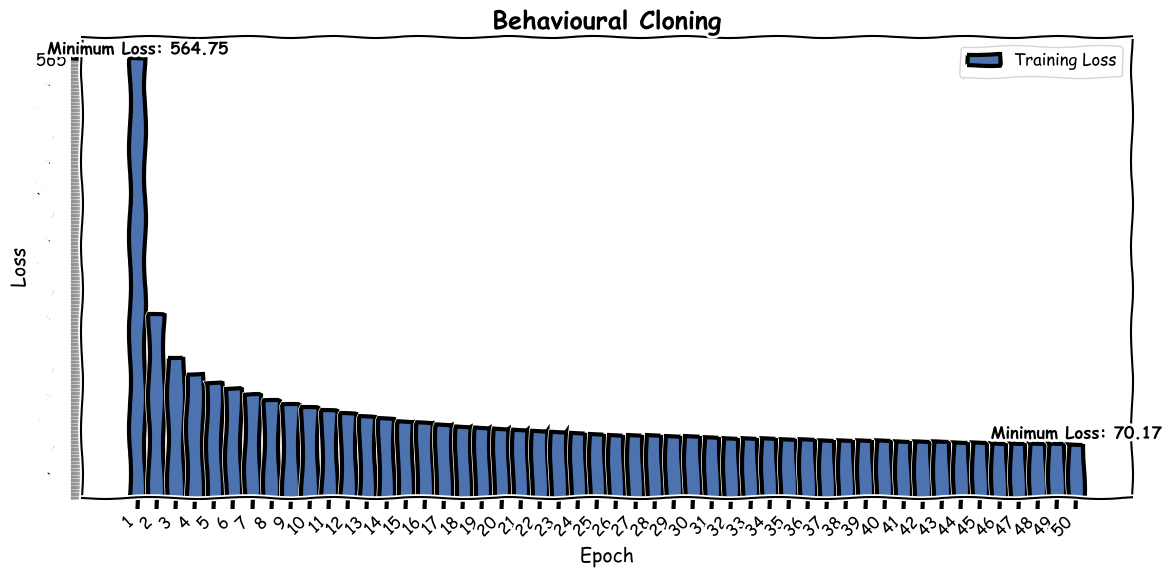

In [71]:
import torch.utils.data as data
bc_model = BCModel(input_dimension= env.observation_space.shape[0], hidden_dimension=128, output_dimension=env.action_space.n)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bc_model.parameters(), lr = 2e-3)

num_epochs = 50
batch_size = 200

states = torch.tensor([data[0] for data in expert_data])
actions = torch.tensor([data[1] for data in expert_data])

# Create a DataLoader for batch training
dataset = data.TensorDataset(states, actions)
dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
losses = []
for epoch in range(num_epochs):
    total_loss = 0
    for batch_states, batch_actions in dataloader:
        optimizer.zero_grad()
        
        outputs = bc_model(batch_states)
        
        loss = criterion(outputs, batch_actions)

        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    losses.append(total_loss)
Plot(losses)
    

Evaluate and render the results.

In [72]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state,_ = env.reset()
for _ in range(300):
    frames.append(env.render())
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    action = torch.argmax(bc_model(state)).item()
    state, reward, done, truncated,_ = env.step(action)
    if (done or truncated):
        break
env.close()
imageio.mimsave('./bc.mp4', frames, fps=25)
show_video('./bc.mp4')

e:\Program_Files\Anaconda\envs\DRL\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
